In [1]:
import os
import glob
import bz2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# Preprocessing the Quotebank data

The idea with this notebook is to load the prefiltered Quotebank data set and preprocess it such that we have an unambiguous data frame that is suitable for future investigations as a pickle. We start by loading the data from each yearly `json.bz2`-file such that the yearly dataframes are concatenated into a single one.

In [2]:
# Specifying filename and directory
data_dir = os.getcwd() + os.sep + 'data'
quotebank_dir = data_dir + os.sep + "Quotebank"
quotebank_bz2 = os.listdir(quotebank_dir)
print(quotebank_bz2)

# Change directory
os.chdir(quotebank_dir)

['quotes-2015-movies.json.bz2', 'quotes-2016-movies.json.bz2', 'quotes-2017-movies.json.bz2', 'quotes-2018-movies.json.bz2', 'quotes-2019-movies.json.bz2', 'quotes-2020-movies.json.bz2']


In [3]:
df = pd.DataFrame()
for year_file in tqdm(quotebank_bz2):
    if year_file != '.DS_Store':
        temp =  pd.read_json(year_file, lines=True, compression='bz2')
        df = pd.concat([df, temp], ignore_index = True) 
df.shape

  0%|          | 0/6 [00:00<?, ?it/s]

(91311, 10)

We check if the filtering was done correctly - just to be sure - such that we also extract quotes about a movie from the following years after the year where it is in the top 10.

In [4]:
np.unique([date.year for date in df.date[df.movie == 'Star Wars: Episode VII - The Force Awakens']], return_counts=True)

(array([2015, 2016]), array([6765, 3408], dtype=int64))

In [5]:
np.unique([date.year for date in df.date[df.movie == 'Star Wars: Episode IX - The Rise of Skywalker']], return_counts=True)

(array([2019, 2020]), array([4628,  793], dtype=int64))

So we see that this is indeed the case. Let's just visualize the data frame to be sure that all attributes are included.

In [6]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2015-02-14-007911,For fans of the book they know that Effie's ro...,None,[],2015-02-14 00:47:05,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,E,The Hunger Games: Mockingjay - Part 2
1,2015-11-15-027947,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15 03:15:53,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,E,The Hunger Games: Mockingjay - Part 2
2,2015-04-26-028061,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26 11:56:10,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,E,Star Wars: Episode VII - The Force Awakens
3,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31 16:48:00,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,E,Star Wars: Episode VII - The Force Awakens
4,2015-12-10-059754,Is Daredevil joining the Avengers for Infinity...,None,[],2015-12-10 23:18:29,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,E,Avengers: Age of Ultron


Removing NaN-values. We see that these only occur in the `movie` attribute which right now is due to an issue in the data filtering. 

In [7]:
df.isnull().any()

quoteID           False
quotation         False
speaker           False
qids              False
date              False
numOccurrences    False
probas            False
urls              False
phase             False
movie             False
dtype: bool

In [8]:
df = df.loc[-df.isnull().any(axis=1)]

In [9]:
df.shape

(91311, 10)

### Dealing with the speakers

We investigate how many quotes does not have an obvious speaker and is denoted by 'None'. Turns out that it is approximately 38%.

In [10]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 34626
Total fraction of 'None'-speakers: 0.37920951473535497


Even though the single speakers are not really important for answering our research questions, we choose to clean the data by chaning 'None'-speakers to the speaker with second highest probability from the `df.probas` attribute.

In [11]:
# Removes speaker as being None to being the second most likely in case speaker is 'None'
proba_threshhold = 0.15

secondary_speaker = [df['probas'][i][1][0] if (speaker == 'None') and (float(df['probas'][i][1][1]) > proba_threshhold) else speaker for i, speaker in enumerate(tqdm(df['speaker']))]
df['speaker'] = secondary_speaker

  0%|          | 0/91311 [00:00<?, ?it/s]

In [12]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 13581
Total fraction of 'None'-speakers: 0.14873344942011368


In [13]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2015-02-14-007911,For fans of the book they know that Effie's ro...,None,[],2015-02-14 00:47:05,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,E,The Hunger Games: Mockingjay - Part 2
1,2015-11-15-027947,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15 03:15:53,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,E,The Hunger Games: Mockingjay - Part 2
2,2015-04-26-028061,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26 11:56:10,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,E,Star Wars: Episode VII - The Force Awakens
3,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31 16:48:00,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,E,Star Wars: Episode VII - The Force Awakens
4,2015-12-10-059754,Is Daredevil joining the Avengers for Infinity...,Scott Davis,[],2015-12-10 23:18:29,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,E,Avengers: Age of Ultron


Furthermore, we realize that there is a super specific timestamp on the `date` attribute. Later on we will match daily box office sales with the Quotebank data, so we strip the timestamps from the specific time of the date and focus solely on the date.

In [14]:
# Remove last part of date from the quoteID date string to be able to have an average daily sentiment score
reduced_dates = [("-").join(date.split("-")[:3]) for date in tqdm(df.quoteID)]
df['date'] = reduced_dates

  0%|          | 0/91311 [00:00<?, ?it/s]

In [15]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2015-02-14-007911,For fans of the book they know that Effie's ro...,None,[],2015-02-14,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,E,The Hunger Games: Mockingjay - Part 2
1,2015-11-15-027947,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,E,The Hunger Games: Mockingjay - Part 2
2,2015-04-26-028061,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,E,Star Wars: Episode VII - The Force Awakens
3,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,E,Star Wars: Episode VII - The Force Awakens
4,2015-12-10-059754,Is Daredevil joining the Avengers for Infinity...,Scott Davis,[],2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,E,Avengers: Age of Ultron


The attribute `phase` seem to mostly take the values 'E'. The investigation below shows that all of the entries are in fact 'E' so we decide to remove it from the dataframe. From the documentation of the data we also do not find it relevant for our case. Also we won't be using the `quoteID` attribute but instead the WikiData compatible `qids`.

In [16]:
np.unique(df.phase, return_counts=True)
df = df.drop(['phase', 'quoteID'], axis=1)

### Handling outliers in the numOccurrences

We want to check for outliers in the number of occurrences as it is the only numercal attribute left. We note that there are no weird negative values as the minimum value of occurrences is 1.

In [17]:
df.numOccurrences.describe()

count    91311.000000
mean         7.700748
std        384.280124
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      58945.000000
Name: numOccurrences, dtype: float64

The boxplot reveals that there is a need to investigate outliers and the plot of the occurences reveal that the distribution seem to follow a strong power law. We will have to qualitatively analyze these to be able to determine whether this tendency seems real or is due to spam. We will determine this later on when we have adjusted the data for other issues.

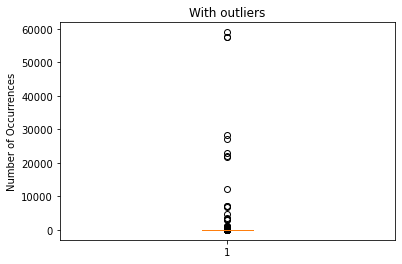

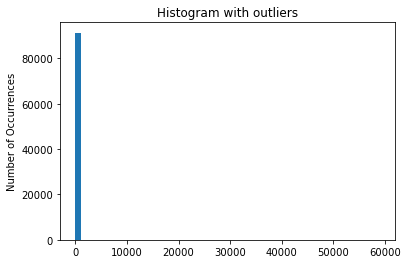

In [18]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences")
plt.title("With outliers")
plt.show()

plt.hist(df.numOccurrences, bins=50)
plt.ylabel("Number of Occurrences")
plt.title("Histogram with outliers")
plt.show()

In [19]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,For fans of the book they know that Effie's ro...,None,[],2015-02-14,1,"[[None, 0.8008], [Francis Lawrence, 0.1299], [...",[http://www.buzzfeed.com/kristinharris/secrets...,The Hunger Games: Mockingjay - Part 2
1,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2
2,It's pretty exciting-I have to say. I saw the ...,None,[],2015-04-26,2,"[[None, 0.8589], [Jared Leto, 0.0772], [Joss W...",[http://ign.com/articles/2015/04/24/joss-whedo...,Star Wars: Episode VII - The Force Awakens
3,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
4,Is Daredevil joining the Avengers for Infinity...,Scott Davis,[],2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron


### Dealing with the quoter-IDs

Furthermore, we see that the `qids` might need some engineering. In the initial analyses on the 2019 NYT data we saw that some individuals are quoted differently even though it's in fact the same speaker. For instance this was the case for the speaker "Donald Trump" and "President Trump". In this case these two denotations share a common qID for which reason we would want to be able to get all quotes from Donald Trump and President Trump when searching for them independently. Even though it might not be as important with movies, we deem it good practice to regulate this behaviour. We start by engineering empty quoteID-lists as an unknown token.

In [20]:
empty = np.array([entry for entry, qID_list in enumerate(df.qids) if len(qID_list) == 0])
print(f"Number of currently unknown qids: {len(empty)}")

Number of currently unknown qids: 34626


In [21]:
pd.options.mode.chained_assignment = None
df['qids'][empty] = [['<UNK>']] * len(empty)

df.qids.head()

0               [<UNK>]
1           [Q16843606]
2               [<UNK>]
3    [Q1507803, Q38222]
4               [<UNK>]
Name: qids, dtype: object

Using this '\<UNK>' token we are able to search the df to replace this token with a qID if the speaker occurs with a qID another place in the data. In this manner all qIDs of a specified speaker will be the full list of qIDs associated with that speaker.

In [22]:
def set_qID(speaker, df):
    #Extract qID's of a speaker
    qIDs = {speaker: list({quote_ID for quote_IDlist in df.qids[df['speaker'] == speaker] for quote_ID in quote_IDlist})}
    
    # Conditions for removing the <UNK> token.
    if len(qIDs[speaker]) > 1 and '<UNK>' in qIDs[speaker]:
        qIDs[speaker].remove('<UNK>')
    
    # Creating new qIDs for replacing in original dataframe
    speaker_indeces = np.where(df.speaker == speaker)[0]
    replacement = pd.Series([qIDs[speaker]] * (sum(df['speaker'] == speaker)), index=speaker_indeces)
    
    # Replace
    df.loc[df['speaker'] == speaker, 'qids'] = replacement

This now works, which can be seen on the speaker George Lucas in the following cells.

In [23]:
df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
3,I want to clarify my interview on the `Charlie...,George Lucas,"[Q1507803, Q38222]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
22,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
40,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
67,a Star Wars for girls,George Lucas,[<UNK>],2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
83,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens


In [24]:
# Calling the function
set_qID('George Lucas', df)

df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
3,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
22,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q38222, Q1507803]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
40,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q38222, Q1507803]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
67,a Star Wars for girls,George Lucas,"[Q38222, Q1507803]",2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
83,We became friends and then we started dating a...,George Lucas,"[Q38222, Q1507803]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens


We want to apply this functionality to the full dataframe (meaning all individual speakers) for which reason we extract the individual speaker names and how frequently quoted they are. We calculate the number of unique quotes for each speaker.

In [25]:
speakers, freq_unsorted = np.unique(df.speaker, return_counts=True)
freq, speakers = np.array(list(zip(*sorted(zip(freq_unsorted, speakers), reverse=True))))

print("Top 10 quoted speakers (w/o numOccurences): ")
list(zip(speakers[:10], freq[:10]))

Top 10 quoted speakers (w/o numOccurences): 


[('None', '13581'),
 ('Kevin Feige', '1802'),
 ('Captain Marvel', '1106'),
 ('Tom Holland', '846'),
 ('Joe Russo', '830'),
 ('Bob Iger', '827'),
 ('Rian Johnson', '790'),
 ('J.J. Abrams', '735'),
 ('Kathleen Kennedy', '703'),
 ('Mark Hamill', '673')]

In [26]:
for speaker in tqdm(speakers):
    set_qID(speaker, df=df)

  0%|          | 0/18186 [00:00<?, ?it/s]

Now, the only way there would be qID's of the name '\<UNK>' would be if the assignment of the predicted speaker is less than 15% percent certain (see `proba_threshhold` in the removal of None-type speakers) and if that same speaker does not have a qID throughout all of the dataframe. In this case we believe there is evidence for deleting the rows.

In [27]:
UNK_idxs = np.array([], dtype=int)
for i, qID in enumerate(tqdm(df.qids)):
    if '<UNK>' in qID:
        UNK_idxs = np.append(UNK_idxs, i)

  0%|          | 0/91311 [00:00<?, ?it/s]

In [28]:
df = df.drop(UNK_idxs)
df.index = np.arange(len(df))
df.shape

(72695, 8)

The following function then concatenates the qID's of speakers if they have more than one qID in common, such that we get exactly the basis for a shared ID if two speakers (like Donald Trump and President Trump) are in fact the same.

In [29]:
def mergeQuoteIDs(df):
    qID_dict = defaultdict(dict)
    print("Creating qID dictionary...")
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        for qid in qid_list:
            if qid in qID_dict:
                qID_dict[qid].append(document_number)
            else:
                qID_dict[qid] = [document_number]
    
    print("Gathering qIDs across documents...")
    new_column = {}
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        document_IDs = []
        for qid in qid_list:
            document_IDs.append(qID_dict[qid])

        related_docs = set(np.concatenate(document_IDs))
        new_qids = list(set(np.concatenate(list(df.qids[related_docs]))))

        new_column[document_number] = new_qids

    df['qids'] = pd.Series(new_column)

In [30]:
mergeQuoteIDs(df)
df.head()

Creating qID dictionary...


  0%|          | 0/72695 [00:00<?, ?it/s]

Gathering qIDs across documents...


  0%|          | 0/72695 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron


And then we create a new ID for each unique list of qID's.

In [31]:
def newID(df):
    unique_IDlists = np.unique(df['qids'])
    newIDs = []
    
    for row_qIDlist in tqdm(df.qids):
        for newID, unique_list in enumerate(unique_IDlists):
            if unique_list == row_qIDlist:
                newIDs.append(newID)
    df['shared_ID'] = newIDs
    
    return newIDs

In [32]:
newIDs = newID(df)

  0%|          | 0/72695 [00:00<?, ?it/s]

In [33]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789


### Dealing with "hidden" duplicated quotes

In the initial analyses on quotes on 2019-nyt-data we realized that some of the quotes appear as multiple rows even though they occur on the same date as other quotes. We realized that this was caused by differing characters that are not letters (like extra 's, punctuations, etc.) which might be due to the Quotebank scraping process or the way newspapers refer to quotes. We find it evident to gather these "hidden" duplicate quotes into one of the versions that gets the numOccurrences and urls updated. This is done in the following cells:

In [34]:
import re

# strip from special characters and remove white spaces for comparing quotes
# we will not use these for other than detecting "hidden" duplicate quotes
quotes = pd.Series([re.sub("[^0-9a-zA-Z]", "", quotation.lower()) for quotation in df.quotation])

# groupby stripped quote
groupedData = df.groupby(by=quotes)

hidden_duplicates = []
ids_to_remove = []

for _, quoteData in tqdm(groupedData):
    # check if stripped quote occurs more than once on the same date
    duplicate_cond = np.all(quoteData.date == quoteData.date.iloc[0])
    if quoteData.__len__() > 1 and duplicate_cond:
        if np.all(quoteData.shared_ID == quoteData.shared_ID.iloc[0]): 
            # determine index to keep and which ones to remove
            keep_id = quoteData.index[0]
            remove_ids = np.setdiff1d(quoteData.index, keep_id)
            
            # update numOccurrences
            numOcc_sum = quoteData.numOccurrences.sum()
            quoteData.loc[keep_id, 'numOccurrences'] = numOcc_sum
            
            # update urls
            quoteData = quoteData.drop(remove_ids)
            new_urls = list(np.concatenate([url for url in quoteData['urls']]))
            quoteData.loc[keep_id, 'urls'] = [[new_urls]] * 1
            
            # collect new columns
            hidden_duplicates.append(quoteData)
            ids_to_remove.append(remove_ids)

if hidden_duplicates.__len__() > 0:
    temp = pd.concat(hidden_duplicates)
    ids_to_remove = np.concatenate(ids_to_remove)

# update original dataframe     
df = df.drop(ids_to_remove)
df.loc[temp.index] = temp
df.index = np.arange(len(df))

  0%|          | 0/71100 [00:00<?, ?it/s]

In [35]:
hidden_duplicates.__len__()

541

In [36]:
print(f"Shape of dataframe: {df.shape}")
df.head()

Shape of dataframe: (72141, 9)


,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789


So now hidden duplicated quotes should be removed.

### Investigating the new ID's

We will now investigate how different ID's (the shared one) are distributed across quotes. We calculate the frequency with which ID is associated, meaning the total number of occurences for each ID.

In [37]:
print(f"Number of unique IDs: {np.max(df.shared_ID)}")

Number of unique IDs: 13561


In [38]:
freq_occurences = defaultdict(dict)

for ID in tqdm(newIDs):
    freq_occurences[ID] = sum(df[df['shared_ID'] == ID].numOccurrences)

  0%|          | 0/72695 [00:00<?, ?it/s]

In [39]:
freq_list = [(ID, count) for ID, count in sorted(freq_occurences.items(), key=lambda item: item[1], reverse=True)]
ID, freq = list(zip(*freq_list))
ID, freq = np.array(ID), np.array(freq)

Using a boxplot we see that the sum of occurences for an ID seem to be affected by outliers and by plotting the amount of occurrences with the speakers sorted in a descending manner, we see that the distribution looks like a strong power law.

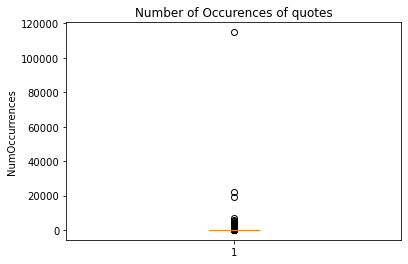

In [40]:
plt.boxplot(freq)
plt.ylabel("NumOccurrences")
plt.title('Number of Occurences of quotes')
plt.show()

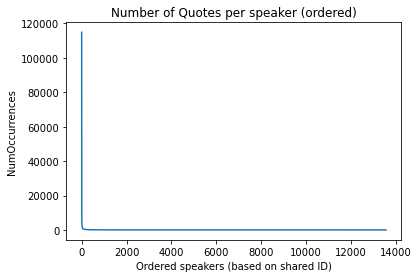

In [41]:
plt.plot(np.arange(len(freq)), freq)
plt.xlabel("Ordered speakers (based on shared ID)")
plt.ylabel("NumOccurrences")
plt.title('Number of Quotes per speaker (ordered)')
plt.show()

We do not regard this as a problem, since it seems reasonable that this depicts the real-world scenario where some people - like star directors and movie stars - have more to say than actors that are not playing in movies at the current time but still gets quoted once in a while, but we will investigate number of occurrences for single quotes in a while

By looking at the shared_ID, we now see that the ambiguity of speakers is now reduced - which will be useful in further analyses - as the new `shared_ID` attribute captures identical speaker denoted by different names.

In [42]:
N = 25
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, max numOccurrences of single quote, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    maxOcc = df[df.shared_ID == ID[n]].numOccurrences.max()
    
    info_tuple = (ID[n], freq[n], maxOcc, list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, max numOccurrences of single quote, associated speakers)

1) (9742, 114892, 57446, ['David Caballero'])

2) (4784, 22007, 22000, ['John Mackey ,'])

3) (6587, 19202, 7073, ['Tom Cruise'])

4) (8789, 6990, 157, ['Kevin Feige', 'KEVIN FEIGE'])

5) (3916, 5986, 525, ['Kathleen Kennedy'])

6) (12174, 5067, 481, ['Peter Parker'])

7) (9362, 4416, 210, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

8) (2394, 3985, 362, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

9) (10998, 3908, 252, ['Rian Johnson', 'RIAN JOHNSON'])

10) (7491, 3626, 341, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

11) (4903, 3572, 388, ['Donald Trump', 'Donald J. Trump', 'President Trump', 'President Donald Trump', 'President Donald J. Trump'])

12) (2483, 3372, 230, ['Ryan Reynolds'])

13) (6942, 2970, 403, ['Captain Marvel', 'Michael Jordan'])

14) (3139, 2953, 184, ['Mark Hamill', 'MARK HAMILL'])

15

### Handling outliers

We realize that some of these can quite plausible be determine as outliers, but we choose to investigate it a bit further and try to find a reasoning for which quotes to include in the end. Let's look at the most occuring quoted ID associated with the speaker David Caballero.

In [43]:
df[df.shared_ID == 9712]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
18300,I've had the good fortune to be able to travel...,Gary Hailes,[Q5525194],2017-05-25,1,"[[Gary Hailes, 0.8981], [None, 0.1019]]",[http://radiotimes.com/news/2017-05-25/meet-th...,Star Wars: Episode VIII - The Last Jedi,9712
21568,So it works-it works perfectly. There is no be...,Gary Hailes,[Q5525194],2017-05-25,1,"[[None, 0.7073], [Gary Hailes, 0.2203], [Barry...",[http://www.radiotimes.com/news/2017-05-25/wha...,Star Wars: Episode VIII - The Last Jedi,9712
28432,I think Star Wars is the most complete version...,Gary Hailes,[Q5525194],2017-05-25,1,"[[None, 0.5944], [Gary Hailes, 0.3286], [Barry...",[http://www.radiotimes.com/news/2017-05-25/wha...,Star Wars: Episode VIII - The Last Jedi,9712


In [44]:
df[df.shared_ID == 9712].urls.iloc[0]

['http://radiotimes.com/news/2017-05-25/meet-the-10000-strong-star-wars-army-conquering-the-world-of-fandom']

This reveals that the high amount of occurrences for these two quotes is most probably due to a mistake in the way the Quotebank data set is constructed. Let's also take a look at the second most occuring speaker, John Machkey.

In [45]:
df[df.shared_ID == 4752]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
11432,He understood there would be an eruption over ...,John the Divine,[Q2733634],2016-08-30,1,"[[None, 0.7145], [John the Divine, 0.2855]]",[http://truro.wickedlocal.com/entertainmentlif...,Captain America: Civil War,4752
11542,"Photo-FILE-In this Nov. 13, 1978 file photo, H...",John the Divine,[Q2733634],2016-12-27,9,"[[John the Divine, 0.3827], [None, 0.3416], [C...",[http://newsok.com/article/5532318/?utm_source...,Star Wars: Episode VII - The Force Awakens,4752
14325,"FILE - In this Nov. 13, 1978 file photo, Harri...",John the Divine,[Q2733634],2016-12-27,9,"[[None, 0.2964], [John the Divine, 0.2952], [H...",[http://newsok.com/article/5532318/?utm_source...,Star Wars: Episode VII - The Force Awakens,4752
14776,Star Wars-Special Edition,John the Divine,[Q2733634],2016-12-28,6,"[[John the Divine, 0.4628], [Carrie Fisher, 0....",[http://www.news.com.au/entertainment/celebrit...,Star Wars: Episode VII - The Force Awakens,4752
15487,"FILE - In this Nov. 13, 1978 file photo, shows...",John the Divine,[Q2733634],2016-12-27,9,"[[John the Divine, 0.3422], [None, 0.3018], [K...",[http://newsok.com/article/5532318/?utm_source...,Star Wars: Episode VII - The Force Awakens,4752
39616,"Grace, an Amazing Homecoming,",John the Divine,[Q2733634],2018-09-27,2,"[[None, 0.7379], [John the Divine, 0.1927], [S...",[http://www.news-gazette.com/arts-entertainmen...,Spider-Man: Homecoming,4752
49966,"I've been promoting Fantastic Beasts, and peop...",John the Divine,[Q2733634],2018-11-06,11,"[[None, 0.3701], [John the Divine, 0.2735], [E...",[http://www.hollywood.com/general/sleep-depriv...,Fantastic Beasts: The Crimes of Grindelwald,4752
71919,In the dystopian world of Beckett's Endgame we...,John the Divine,[Q2733634],2020-02-12,1,"[[None, 0.4448], [John the Divine, 0.4351], [G...",[https://www.broadwayworld.com/bwwclassical/ar...,Avengers: Endgame,4752


In [46]:
df[df.shared_ID == 4752].urls.iloc[0]

['http://truro.wickedlocal.com/entertainmentlife/20160830/mac-gatch-and-history-of-progressive-preachers']

Same tendency - it feels safe to remove these quotes from the data frame, but where do we put the limit when we don't have the time nor ressources to inspect all quotes manually? 

We aim at solving this issue by setting a threshold on the `numOccurrences` attribute. The positive side of this approach is that we are 100% certain that spam or mistaken data will be removed. However, we risk that quotes that are in fact just popular and highly quoted are removed even though they are not spam or caused by a mistake in the Quotebank data retrieval approach, which will result in a loss of important data.

In continuation of this we must be aware that multiple versions of the same quote can occur as different entries in the Quotebank data set as each quote has a `date` attached. We argue that this gives evidence to our threshhold-based quote-removal approach as it seems rather unlikely that the same quote occurs on multiple valid urls on the same date. Our line of thought is that it for sure is possible to have a high number of occurrences due to the huge amount of possible quotations by worldwide newspaper webpages, etc., but as we are working with movie data - which we do not classify as "breaking news" - it seems more likely that the representation of the quote around the world happens across multiple days.

We would rather not have false data in our analyses and choose a threshold of a quote occuring maximum 20 times a day based on the previous arguments and our intuitive knowledge of the media coverage on movies and quotations. Below we calculate the percentage of data that is removed with this threshold.

In [47]:
print(f"Percentage of data regarded as outliers: {np.round((df.numOccurrences > 20).sum() / df.__len__(), 4)*100}%")

Percentage of data regarded as outliers: 2.41%


In [48]:
df = df[df.numOccurrences < 20]
df.index = np.arange(df.__len__())

We do the same exploration as before we removed the "outliers".

In [49]:
print(f"Number of unique IDs: {np.max(df.shared_ID)}")

Number of unique IDs: 13561


In [50]:
freq_occurences = defaultdict(dict)

for ID in tqdm(newIDs):
    freq_occurences[ID] = sum(df[df['shared_ID'] == ID].numOccurrences)

  0%|          | 0/72695 [00:00<?, ?it/s]

In [51]:
freq_list = [(ID, count) for ID, count in sorted(freq_occurences.items(), key=lambda item: item[1], reverse=True)]
ID, freq = list(zip(*freq_list))
ID, freq = np.array(ID), np.array(freq)

The boxplot and second plot still reveal that some speakers are more likely to be quoted than others. As previously mentioned this is reasonable.

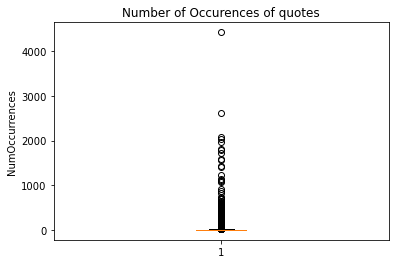

In [52]:
plt.boxplot(freq)
plt.ylabel("NumOccurrences")
plt.title('Number of Occurences of quotes')
plt.show()


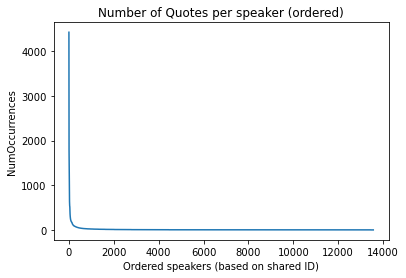

In [53]:
plt.plot(np.arange(len(freq)), freq)
plt.xlabel("Ordered speakers (based on shared ID)")
plt.ylabel("NumOccurrences")
plt.title('Number of Quotes per speaker (ordered)')
plt.show()

And now the top 25 most quoted speakers look like this.

In [54]:
N = 25
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, max numOccurrences of single quote, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    maxOcc = df[df.shared_ID == ID[n]].numOccurrences.max()
    
    info_tuple = (ID[n], freq[n], maxOcc, list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, max numOccurrences of single quote, associated speakers)

1) (8789, 4427, 19, ['Kevin Feige', 'KEVIN FEIGE'])

2) (9362, 2627, 19, ['Bob Iger', 'Robert Iger', 'Robert A. Iger', 'BOB IGER'])

3) (2394, 2071, 19, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (1812, 2034, 19, ['Joe Russo', 'Joseph Russo', 'joe russo'])

5) (6942, 1979, 19, ['Captain Marvel', 'Michael Jordan'])

6) (10998, 1806, 19, ['Rian Johnson', 'RIAN JOHNSON'])

7) (2867, 1784, 19, ['Tom Holland', 'TOM HOLLAND'])

8) (7491, 1714, 17, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

9) (3916, 1593, 19, ['Kathleen Kennedy'])

10) (3139, 1573, 18, ['Mark Hamill', 'MARK HAMILL'])

11) (6724, 1436, 19, ['George Lucas', 'GEORGE LUCAS'])

12) (2273, 1418, 19, ['Gal Gadot'])

13) (2483, 1235, 19, ['Ryan Reynolds'])

14) (1583, 1130, 17, ['Robert Downey', 'Robert Downey Jr. .', 'ROBERT DOWNEY JR. .'])

15) (9550, 1112, 19, 

### Saving the dataframe
We save the Quotebank data frame in a pickle for easy access.

In [55]:
# Save loaded DataFrame as pickle for faster loading time in the future
filename = f"Quotebank_processed"
df.to_pickle(rf"{data_dir}{os.sep}{filename}.pkl")

print(f"Dataframe was pickled and saved to directory:\n{data_dir} \n")
print(f"Shape of dataframe: {df.shape}")

Dataframe was pickled and saved to directory:
C:\Users\Albert Kjøller\Documents\EPFL\Courses\CS-401_ADA\ada-2021-project-f-jab\exploratory\data 

Shape of dataframe: (70297, 9)


### (Optional) - All occurrences per speaker

In [ ]:
N = len(df)-1
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")